Initial data shape: (6162, 97)
        id institutionCode  collectionCode  ownerInstitutionCode  \
0  3077805             FNL             NaN                   NaN   
1  3077806             FNL             NaN                   NaN   
2  3077807             FNL             NaN                   NaN   
3  3077808             FNL             NaN                   NaN   
4  3077809             FNL             NaN                   NaN   

       basisOfRecord  occurrenceID catalogNumber  otherCatalogNumbers  \
0  PreservedSpecimen           NaN       FI1-001                  NaN   
1  PreservedSpecimen           NaN       FI1-002                  NaN   
2  PreservedSpecimen           NaN       FI1-003                  NaN   
3  PreservedSpecimen           NaN       FI1-004                  NaN   
4  PreservedSpecimen           NaN       FI1-005                  NaN   

                                higherClassification kingdom  ...  \
0  Fungi|Basidiomycota|Agaricomycotina|Agaricomyc...

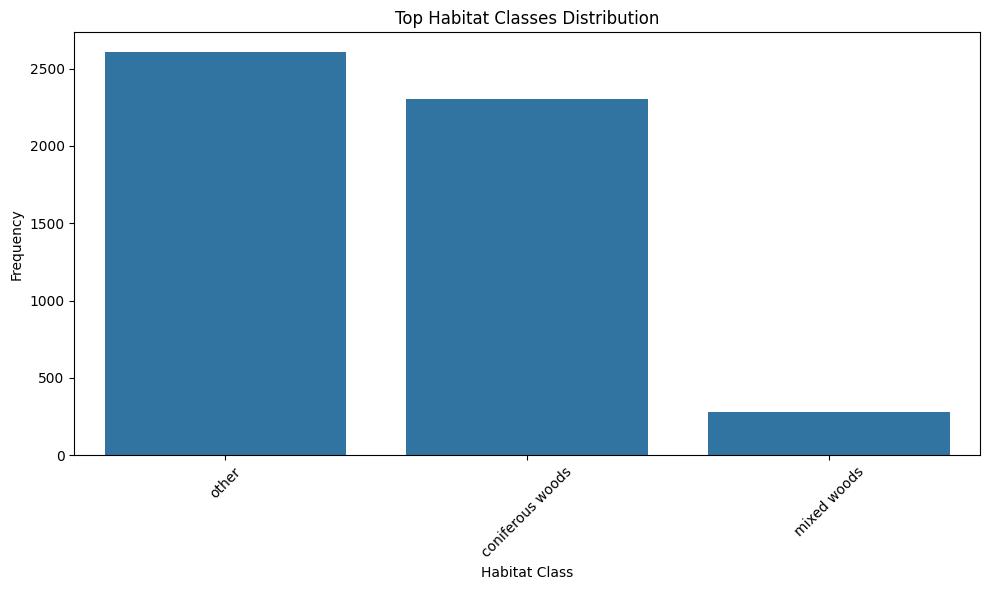

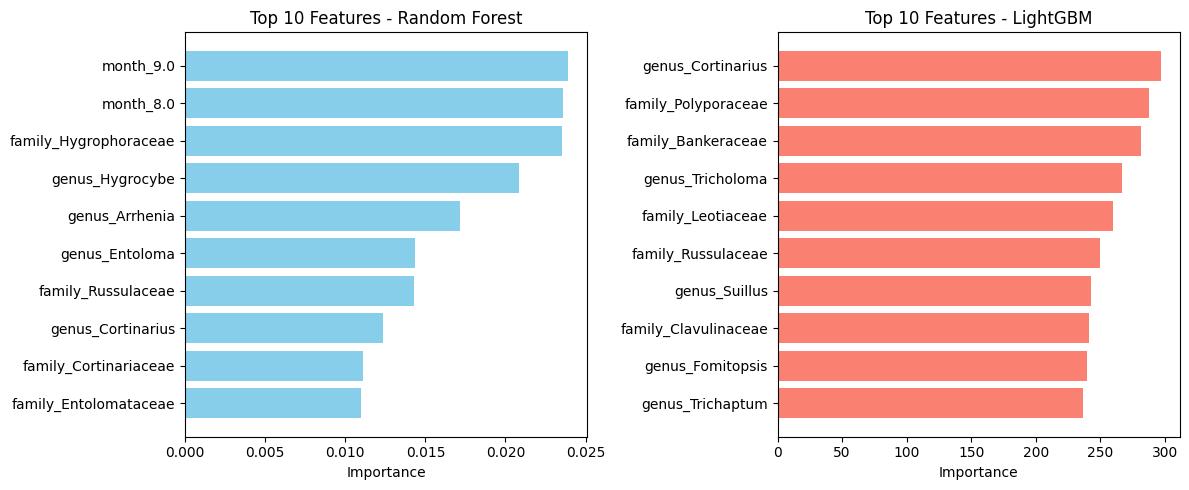

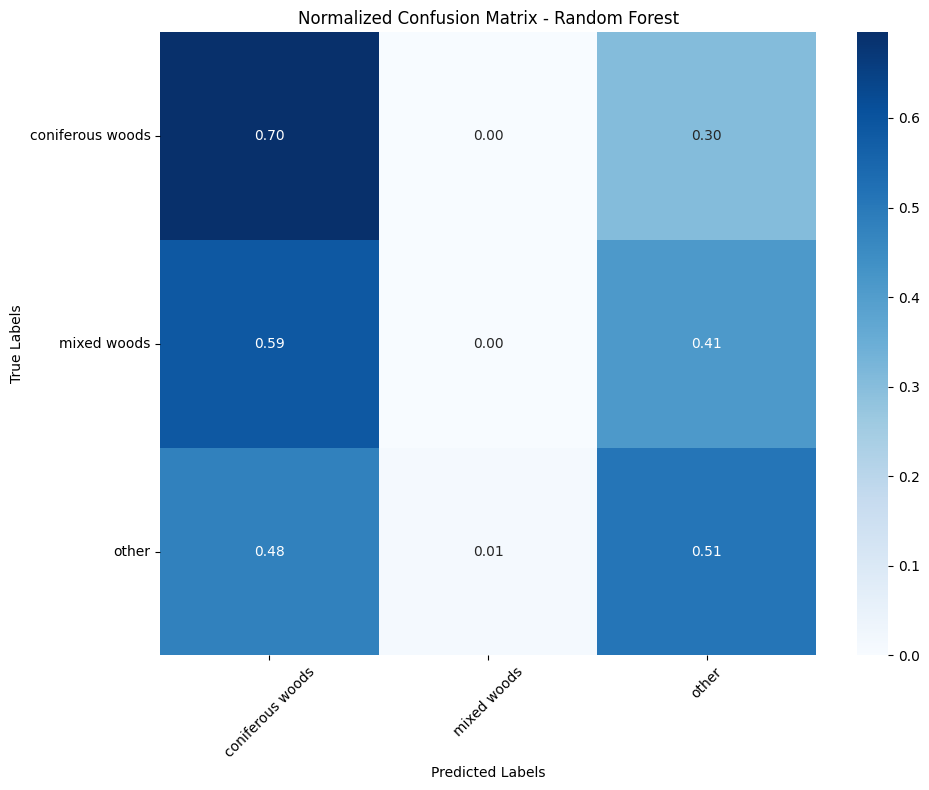

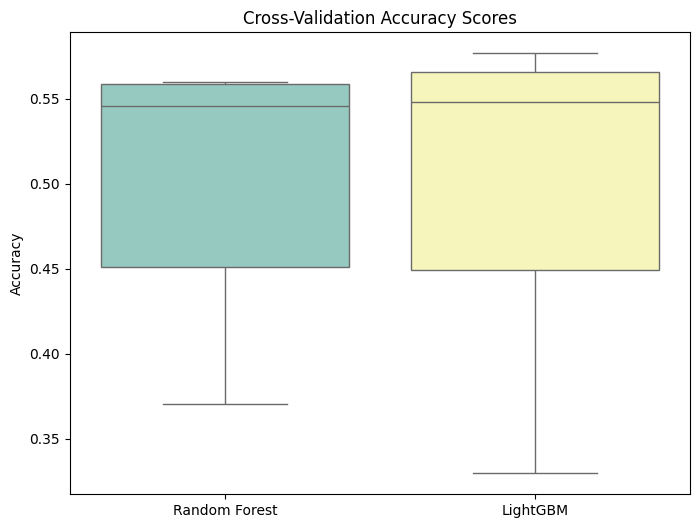

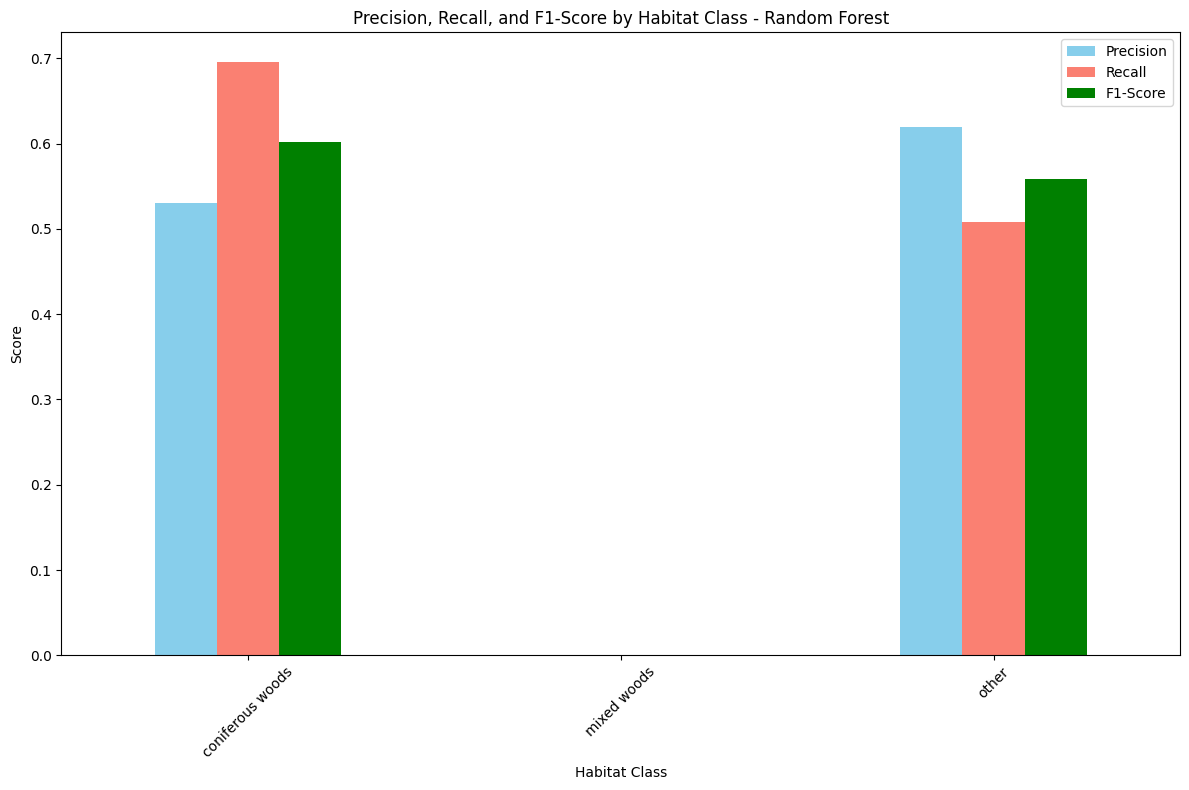

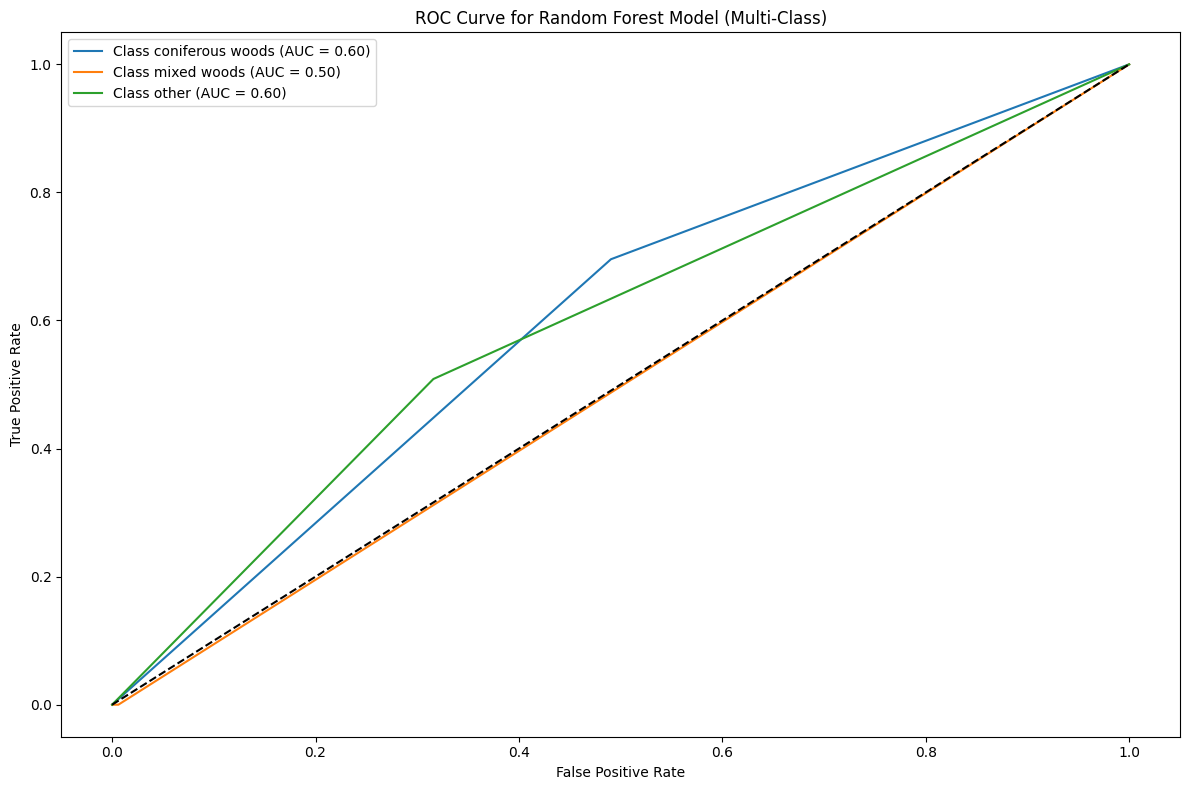

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

# Step 1: Load and explore data
dataset_path = '/content/occurrences.csv'
data = pd.read_csv(dataset_path, encoding='ISO-8859-1')
print("Initial data shape:", data.shape)
print(data.head())

# Step 2: Data Preparation and Cleaning
cleaned_data = data[['family', 'genus', 'month', 'habitat']].dropna()

# Standardize habitat labels and retain top categories
top_habitats = cleaned_data['habitat'].value_counts().index[:5].tolist()
cleaned_data['habitat'] = cleaned_data['habitat'].apply(lambda x: x if x in top_habitats else 'Other')
cleaned_data['habitat'] = cleaned_data['habitat'].str.lower().str.strip()
cleaned_data['habitat'] = cleaned_data['habitat'].replace({'coniferous forest': 'coniferous woods'})

# Encode categorical features
model_data = pd.get_dummies(cleaned_data, columns=['family', 'genus', 'month'], drop_first=True)

# Separate features and target variable
X = model_data.drop('habitat', axis=1)
y = cleaned_data['habitat']

# Step 3: Label Encoding for Target Variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)

# Step 4: Feature Scaling and Data Splitting
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Step 5: Cross-Validation and Hyperparameter Tuning - Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Step 6: Cross-Validation and Hyperparameter Tuning - LightGBM
param_grid_lgbm = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150]
}
lgbm = LGBMClassifier(random_state=42)
grid_lgbm = GridSearchCV(lgbm, param_grid_lgbm, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)
grid_lgbm.fit(X_train, y_train)
best_lgbm = grid_lgbm.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_test)

# Step 7: Visualization of Top Habitat Classes
plt.figure(figsize=(10, 6))
sns.countplot(data=cleaned_data, x='habitat', order=cleaned_data['habitat'].value_counts().index)
plt.title("Top Habitat Classes Distribution")
plt.xlabel("Habitat Class")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 8: Feature Importances from Random Forest and LightGBM
feature_importances_rf = best_rf.feature_importances_
feature_importances_lgbm = best_lgbm.feature_importances_
indices_rf = np.argsort(feature_importances_rf)[-10:]
indices_lgbm = np.argsort(feature_importances_lgbm)[-10:]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.barh(range(len(indices_rf)), feature_importances_rf[indices_rf], align='center', color='skyblue')
plt.yticks(range(len(indices_rf)), [X.columns[i] for i in indices_rf])
plt.title("Top 10 Features - Random Forest")
plt.xlabel("Importance")

plt.subplot(1, 2, 2)
plt.barh(range(len(indices_lgbm)), feature_importances_lgbm[indices_lgbm], align='center', color='salmon')
plt.yticks(range(len(indices_lgbm)), [X.columns[i] for i in indices_lgbm])
plt.title("Top 10 Features - LightGBM")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Step 9: Normalized Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt=".2f", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Normalized Confusion Matrix - Random Forest")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Step 10: Cross-Validation Accuracy Visualization
cv_rf = cross_val_score(best_rf, X_scaled, y_encoded, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)
cv_lgbm = cross_val_score(best_lgbm, X_scaled, y_encoded, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)

plt.figure(figsize=(8, 6))
sns.boxplot(data=[cv_rf, cv_lgbm], palette="Set3")
plt.xticks([0, 1], ['Random Forest', 'LightGBM'])
plt.title("Cross-Validation Accuracy Scores")
plt.ylabel("Accuracy")
plt.show()

# Step 11: Metrics by Habitat Class for Random Forest
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_rf, labels=np.unique(y_test), zero_division=0)
metrics_df = pd.DataFrame({
    'Habitat': label_encoder.inverse_transform(np.unique(y_test)),
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})
metrics_df.set_index('Habitat', inplace=True)
metrics_df.plot(kind='bar', figsize=(12, 8), color=['skyblue', 'salmon', 'green'])
plt.title("Precision, Recall, and F1-Score by Habitat Class - Random Forest")
plt.xlabel("Habitat Class")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 12: ROC Curve for Multi-Class Classification
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
y_pred_rf_binarized = label_binarize(y_pred_rf, classes=np.unique(y_test))

fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(12, 8))
for i in range(y_test_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_rf_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"Class {label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Random Forest Model (Multi-Class)")
plt.legend(loc="best")
plt.tight_layout()
plt.show()
